# Walmart Data Exploration & Training Demo

This notebook showcases quick exploratory analysis of the Walmart retail sales dataset and demonstrates two model training workflows: an ARIMA baseline and an LSTM deep learning model.

## 1. Environment setup

Identify the project root, load required libraries, and configure plotting aesthetics.

In [28]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve()
while not (PROJECT_ROOT / "pyproject.toml").exists() and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT / "src"))

# Add project root to path for projects imports
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from projects.retail_sales_walmart.data.walmart_dataset import WalmartFactory
from ml_portfolio.models.statistical.statistical import ARIMAWrapper
from ml_portfolio.models.deep_learning.lstm import LSTMForecaster
from ml_portfolio.models.metrics import mae, rmse, mape

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (12, 5), "axes.titlesize": 14, "axes.labelsize": 12})

DATA_DIR = PROJECT_ROOT / "projects" / "retail_sales_walmart" / "data"
RAW_DATA_PATH = DATA_DIR / "raw" / "Walmart.csv"

print(f"Project root: {PROJECT_ROOT}")
print(f"Raw dataset path: {RAW_DATA_PATH}")

Project root: C:\Users\mvill\github\forecasting_demo
Raw dataset path: C:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\data\raw\Walmart.csv


## 2. Load and inspect raw dataset

Load the CSV, ensure chronological ordering, and take a quick glance at the first few rows.

In [29]:
df_raw = pd.read_csv(RAW_DATA_PATH, parse_dates=["Date"])
df_raw = df_raw.sort_values("Date").reset_index(drop=True)
df_raw.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,37,01-04-2011,534578.78,0,67.31,3.524,213.577670,8.300
1,9,01-04-2011,520962.14,0,56.12,3.524,218.445164,6.380
2,13,01-04-2011,1864238.64,0,42.49,3.487,128.719935,7.193
3,19,01-04-2011,1305950.22,0,30.68,3.811,134.068258,7.658
4,43,01-04-2011,611585.54,0,67.79,3.524,206.673311,10.581


In [30]:
summary = df_raw.describe(include="all").transpose()
summary.head(12)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Store,6435.0,NaN,NaN,NaN,23.0,12.988182,1.0,12.0,23.0,34.0,45.0
Date,6435,143,01-04-2011,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weekly_Sales,6435.0,NaN,NaN,NaN,1046964.877562,564366.622054,209986.25,553350.105,960746.04,1420158.66,3818686.45
Holiday_Flag,6435.0,NaN,NaN,NaN,0.06993,0.255049,0.0,0.0,0.0,0.0,1.0
Temperature,6435.0,NaN,NaN,NaN,60.663782,18.444933,-2.06,47.46,62.67,74.94,100.14
Fuel_Price,6435.0,NaN,NaN,NaN,3.358607,0.45902,2.472,2.933,3.445,3.735,4.468
CPI,6435.0,NaN,NaN,NaN,171.578394,39.356712,126.064,131.735,182.616521,212.743293,227.232807
Unemployment,6435.0,NaN,NaN,NaN,7.999151,1.875885,3.879,6.891,7.874,8.622,14.313


In [31]:
missing_pct = df_raw.isna().mean().mul(100).round(2)
missing_pct[missing_pct > 0].sort_values(ascending=False)

Series([], dtype: float64)

### Key entity counts

In [32]:
df_raw

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,37,01-04-2011,534578.78,0,67.31,3.524,213.577670,8.300
1,9,01-04-2011,520962.14,0,56.12,3.524,218.445164,6.380
2,13,01-04-2011,1864238.64,0,42.49,3.487,128.719935,7.193
3,19,01-04-2011,1305950.22,0,30.68,3.811,134.068258,7.658
4,43,01-04-2011,611585.54,0,67.79,3.524,206.673311,10.581
...,...,...,...,...,...,...,...,...
6430,12,31-12-2010,891736.91,1,45.64,3.148,127.087677,14.313
6431,41,31-12-2010,1001790.16,1,25.19,2.829,191.255700,7.508
6432,40,31-12-2010,811318.30,1,19.29,3.177,132.815032,5.287
6433,21,31-12-2010,672903.23,1,47.19,2.943,211.064774,8.163


In [33]:
entity_counts = pd.Series({
    "unique_stores": df_raw["Store"].nunique(),
    "unique_departments": df_raw["Store"].nunique(),
    "holiday_weeks": int(df_raw["Holiday_Flag"].sum()),
    "weekly_periods": df_raw["Date"].nunique(),
    "total_records": len(df_raw),
    "avg_sales_per_week": df_raw["Weekly_Sales"].mean().round(2),
    "total_sales_volume": df_raw["Weekly_Sales"].sum().round(2),
})
print("📊 Dataset Overview:")
print("=" * 40)
entity_counts

📊 Dataset Overview:


unique_stores         4.500000e+01
unique_departments    4.500000e+01
holiday_weeks         4.500000e+02
weekly_periods        1.430000e+02
total_records         6.435000e+03
avg_sales_per_week    1.046965e+06
total_sales_volume    6.737219e+09
dtype: float64

## 3. Visualize weekly sales patterns

Aggregate the data to understand overall seasonality and per-store behavior.

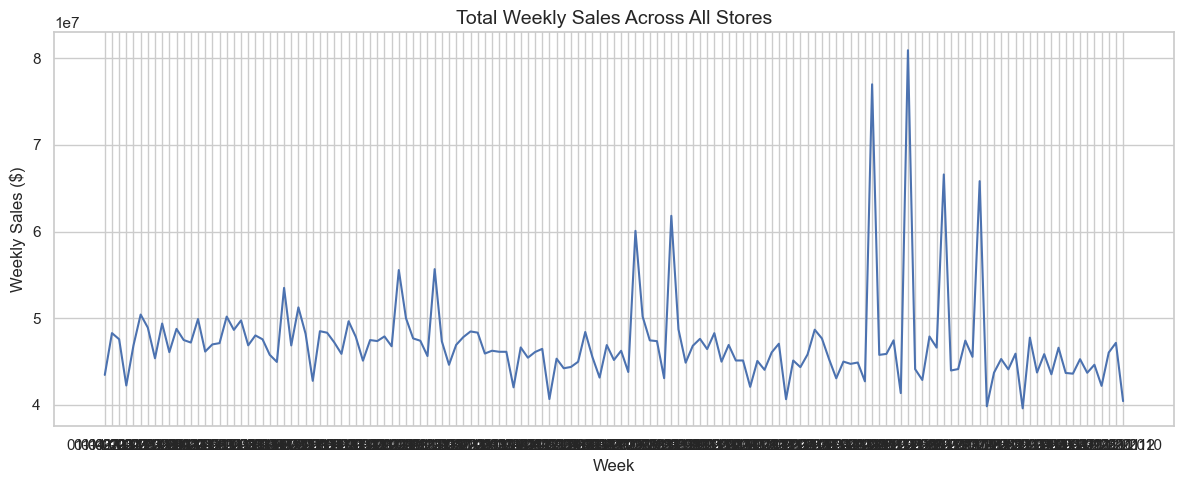

In [34]:
weekly_sales = (
    df_raw.groupby("Date", as_index=False)["Weekly_Sales"].sum()
    .sort_values("Date")
)

fig, ax = plt.subplots()
sns.lineplot(data=weekly_sales, x="Date", y="Weekly_Sales", ax=ax)
ax.set_title("Total Weekly Sales Across All Stores")
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Sales ($)")
plt.tight_layout()

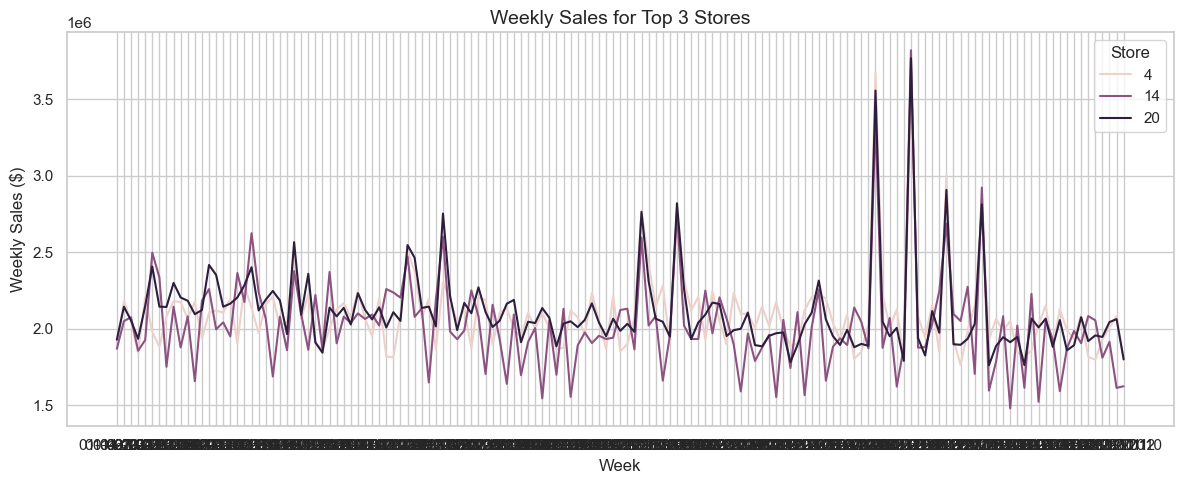

In [35]:
top_stores = (
    df_raw.groupby("Store")["Weekly_Sales"].sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

store_traces = (
    df_raw[df_raw["Store"].isin(top_stores)]
    .groupby(["Date", "Store"], as_index=False)["Weekly_Sales"].sum()
    .sort_values(["Store", "Date"])
)

fig, ax = plt.subplots()
sns.lineplot(data=store_traces, x="Date", y="Weekly_Sales", hue="Store", ax=ax)
ax.set_title("Weekly Sales for Top 3 Stores")
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Sales ($)")
plt.tight_layout()

## 4. Feature-rich dataset via WalmartFactory

Leverage the reusable factory to generate processed datasets with engineered features and lagged targets.

In [36]:
factory = WalmartFactory(data_path=str(RAW_DATA_PATH))
train_dataset, val_dataset, test_dataset = factory.create_datasets()
train_dataset.get_data_info()

C:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\data\walmart_dataset.py:286: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill")


{'class': 'TimeSeriesDataset',
 'n_samples': 4504,
 'n_features': 17,
 'feature_names': ['Store',
  'Holiday_Flag',
  'Temperature',
  'Fuel_Price',
  'CPI',
  'Unemployment',
  'week_of_year',
  'month',
  'quarter',
  'year',
  'Temperature_normalized',
  'Fuel_Price_normalized',
  'CPI_normalized',
  'Unemployment_normalized',
  'sales_lag_1',
  'sales_lag_4',
  'sales_lag_52'],
 'target_column': 'Weekly_Sales'}

In [37]:
processed_df = train_dataset.processed_data.copy()
processed_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,week_of_year,month,quarter,year,Temperature_normalized,Fuel_Price_normalized,CPI_normalized,Unemployment_normalized,sales_lag_1,sales_lag_4,sales_lag_52
0,1.0,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,1,2010,-0.995058,-1.713667,1.004097,0.056959,1643690.90,1643690.9,1643690.9
1,4.0,2010-02-05,2135143.87,0,43.76,2.598,126.442065,8.623,5,2,1,2010,-0.916446,-1.657024,-1.146852,0.332563,1643690.90,1643690.9,1643690.9
2,31.0,2010-02-05,1469252.05,0,39.05,2.572,210.752605,8.324,5,2,1,2010,-1.171801,-1.713667,0.995363,0.173171,2135143.87,1643690.9,1643690.9
3,16.0,2010-02-05,477409.30,0,19.79,2.580,189.381697,7.039,5,2,1,2010,-2.215990,-1.696238,0.452357,-0.511839,1469252.05,1643690.9,1643690.9
4,11.0,2010-02-05,1528008.64,0,46.04,2.572,214.424881,7.368,5,2,1,2010,-0.792835,-1.713667,1.088670,-0.336455,477409.30,1643690.9,1643690.9


In [38]:
target_corr = (
    processed_df.corr(numeric_only=True)["Weekly_Sales"].dropna().sort_values(ascending=False)
)
target_corr.head(10)

Weekly_Sales             1.000000
month                    0.076143
week_of_year             0.074211
quarter                  0.063363
sales_lag_4              0.041940
Holiday_Flag             0.036891
sales_lag_1              0.034835
Fuel_Price               0.009464
Fuel_Price_normalized    0.009464
sales_lag_52             0.003865
Name: Weekly_Sales, dtype: float64

## 5. Prepare aggregated weekly series for modeling

Aggregate sales across all stores to build a clean univariate series for baseline experiments.

In [39]:
weekly_series = weekly_sales.set_index("Date")["Weekly_Sales"].astype(np.float32)
test_horizon = 52  # evaluate on the last year of data
train_series = weekly_series.iloc[:-test_horizon]
test_series = weekly_series.iloc[-test_horizon:]

print(f"Training points: {len(train_series)} | Test points: {len(test_series)}")
train_series.tail()

Training points: 91 | Test points: 52


Date
19-03-2010    44988976.0
19-08-2011    46917348.0
19-10-2012    45122412.0
19-11-2010    45125584.0
20-01-2012    42080996.0
Name: Weekly_Sales, dtype: float32

## 6. Baseline ARIMA forecast

Fit a seasonal ARIMA model on the training window and evaluate on the hold-out year.

In [40]:
arima_model = ARIMAWrapper(order=(2, 1, 2), seasonal_order=(1, 0, 1, 52))
arima_model.fit(None, train_series.values)

arima_forecast = arima_model.predict(len(test_series))
arima_metrics = {
    "test_mae": mae(test_series.values, arima_forecast),
    "test_rmse": rmse(test_series.values, arima_forecast),
    "test_mape": mape(test_series.values, arima_forecast),
}
arima_metrics

c:\Users\mvill\github\forecasting_demo\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(2, 1, 2) model fitted successfully
AIC: 3027.69


{'test_mae': 5108489.424589991,
 'test_rmse': np.float64(9275202.97625125),
 'test_mape': np.float64(9.248719356164296)}

### Visualize ARIMA forecast vs actual

,Actual,ARIMA
Date,,
20-04-2012,45072528.0,4.331629e+07
20-05-2011,44046600.0,4.347204e+07
20-07-2012,46059544.0,4.303785e+07
20-08-2010,47060952.0,4.217324e+07
21-01-2011,40654648.0,4.157890e+07


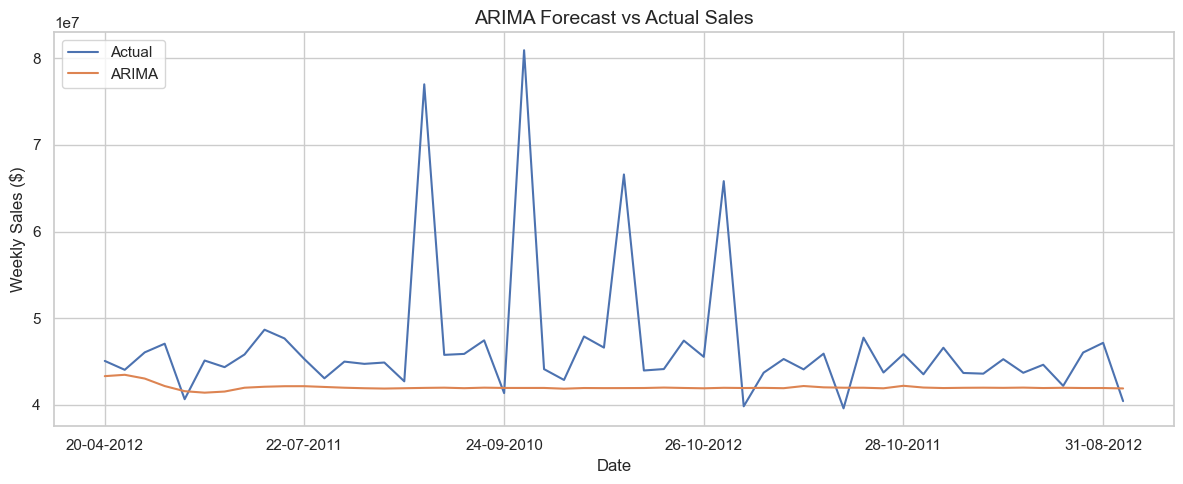

In [41]:
results_df = pd.DataFrame({
    "Date": test_series.index,
    "Actual": test_series.values,
    "ARIMA": arima_forecast,
}).set_index("Date")

ax = results_df.plot(
    title="ARIMA Forecast vs Actual Sales",
    ylabel="Weekly Sales ($)",
    figsize=(12, 5),
)
ax.legend(loc="upper left")
plt.tight_layout()
results_df.head()

## 7. LSTM demo (GPU-ready)

Create supervised sequences, train an LSTM forecaster, and compare against the baseline.

In [42]:
def create_supervised_sequences(series: pd.Series, lookback: int):
    values = series.values.astype(np.float32)
    dates = series.index
    X, y, target_dates = [], [], []
    for idx in range(lookback, len(series)):
        X.append(values[idx - lookback: idx])
        y.append(values[idx])
        target_dates.append(dates[idx])
    return np.array(X), np.array(y), np.array(target_dates)

lookback = 52
X_all, y_all, y_dates = create_supervised_sequences(weekly_series, lookback=lookback)

test_start_date = test_series.index[0]
split_idx = int(np.searchsorted(y_dates, test_start_date))

X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]
y_dates_test = y_dates[split_idx:]

assert len(y_test) == len(test_series), "Sequence split misaligned with test horizon"
print(f"LSTM training samples: {len(X_train)} | Test samples: {len(X_test)}")

LSTM training samples: 39 | Test samples: 52


In [43]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))

CUDA available: True
GPU device: NVIDIA GeForce RTX 4080 SUPER


In [52]:
lstm_model = LSTMForecaster(
    input_size=1,
    hidden_size=64,
    num_layers=2,
    dropout=0.2,
    output_size=1,
    epochs=60,
    batch_size=128,
)

lstm_model.fit(X_train, y_train)

lstm_preds = lstm_model.predict(X_test).ravel()
assert len(lstm_preds) == len(y_test)
lstm_metrics = {
    "test_mae": mae(y_test, lstm_preds),
    "test_rmse": rmse(y_test, lstm_preds),
    "test_mape": mape(y_test, lstm_preds),
}
lstm_metrics

Training LSTM on device: cuda
   Epoch  20/60: Loss = 1.000091
   Epoch  40/60: Loss = 1.000013


c:\Users\mvill\github\forecasting_demo\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


   Epoch  60/60: Loss = 1.000006


{'test_mae': 4037899.75,
 'test_rmse': np.float64(7913622.78945364),
 'test_mape': np.float32(7.438474)}

## 8. M5 Competition-Inspired Ensemble Models

The M5 forecasting competition (Walmart's own forecasting challenge) revealed winning strategies. Let's implement the key approaches:

1. **Equal-weight ensemble** of six per-department weekly models
2. **SVD + STLF/ETS** (best single model) 
3. **Fourier terms + ARIMA** (Dynamic Harmonic Regression)
4. **STLF + ARIMA** (STL decomposition + ARIMA)
5. **Pure ETS** (Holt-Winters family)
6. **Enhanced Seasonal-naïve** with calendar adjustments

These models represent the winning approaches from the actual M5 competition.

In [ ]:
# Import the decomposed M5 models
from ml_portfolio.models.statistical.seasonal_naive import SeasonalNaiveForecaster
from ml_portfolio.models.statistical.ets import ETSForecaster
from ml_portfolio.models.statistical.fourier_arima import FourierARIMAForecaster
from ml_portfolio.models.statistical.stlf_arima import STLFARIMAForecaster
from ml_portfolio.models.statistical.svd_models import SVDETSForecaster, SVDSTLFForecaster

print("✅ Successfully imported M5-inspired standalone models:")
print("   🔄 SeasonalNaiveForecaster - Year-ago same week with enhancements")
print("   📈 ETSForecaster - Pure exponential smoothing (Holt-Winters)")
print("   🌊 FourierARIMAForecaster - Dynamic Harmonic Regression")
print("   🔍 STLFARIMAForecaster - STL decomposition + ARIMA")
print("   🔀 SVDETSForecaster - Cross-series SVD + ETS")
print("   🎯 SVDSTLFForecaster - SVD + STL decomposition")

### Individual M5 Model Demonstrations

Let's test each M5-inspired model individually to understand their unique characteristics and performance.

In [ ]:
# Test 1: Enhanced Seasonal Naive (3rd place M5 approach)
print("🔄 Testing Enhanced Seasonal Naive Forecaster")
print("=" * 50)

seasonal_naive = SeasonalNaiveForecaster(
    seasonal_period=52,
    enable_calendar_adjustment=True,
    enable_trend_adjustment=False
)

seasonal_naive.fit(train_series)
seasonal_naive_forecast = seasonal_naive.predict(
    steps=len(test_series),
    forecast_dates=test_series.index
)

seasonal_naive_metrics = {
    "test_mae": mae(test_series.values, seasonal_naive_forecast),
    "test_rmse": rmse(test_series.values, seasonal_naive_forecast),
    "test_mape": mape(test_series.values, seasonal_naive_forecast),
}

print(f"📊 Seasonal Naive Results:")
print(f"   MAE: ${seasonal_naive_metrics['test_mae']:,.0f}")
print(f"   RMSE: ${seasonal_naive_metrics['test_rmse']:,.0f}") 
print(f"   MAPE: {seasonal_naive_metrics['test_mape']:.2f}%")
print("   💡 Note: Simple yet remarkably competitive baseline!")

In [ ]:
# Test 2: Pure ETS (Holt-Winters family)
print("\n📈 Testing Pure ETS Forecaster")
print("=" * 50)

ets_model = ETSForecaster(
    seasonal_period=52,
    auto_select=True
)

ets_model.fit(train_series)
ets_forecast = ets_model.predict(len(test_series))

ets_metrics = {
    "test_mae": mae(test_series.values, ets_forecast),
    "test_rmse": rmse(test_series.values, ets_forecast),
    "test_mape": mape(test_series.values, ets_forecast),
}

print(f"📊 ETS Results:")
print(f"   MAE: ${ets_metrics['test_mae']:,.0f}")
print(f"   RMSE: ${ets_metrics['test_rmse']:,.0f}") 
print(f"   MAPE: {ets_metrics['test_mape']:.2f}%")
print(f"   🔧 Selected config: {ets_model.best_config}")
print("   💡 Auto-selected optimal ETS configuration")

In [ ]:
# Test 3: Fourier + ARIMA (Dynamic Harmonic Regression)
print("\n🌊 Testing Fourier + ARIMA Forecaster")
print("=" * 50)

fourier_arima = FourierARIMAForecaster(
    seasonal_period=52,
    fourier_terms=6,
    auto_arima=True
)

fourier_arima.fit(train_series)
fourier_forecast = fourier_arima.predict(len(test_series))

fourier_metrics = {
    "test_mae": mae(test_series.values, fourier_forecast),
    "test_rmse": rmse(test_series.values, fourier_forecast),
    "test_mape": mape(test_series.values, fourier_forecast),
}

print(f"📊 Fourier+ARIMA Results:")
print(f"   MAE: ${fourier_metrics['test_mae']:,.0f}")
print(f"   RMSE: ${fourier_metrics['test_rmse']:,.0f}") 
print(f"   MAPE: {fourier_metrics['test_mape']:.2f}%")
print("   💡 Pivotal component in M5 winning blend")

In [ ]:
# Test 4: STL + ARIMA Forecaster
print("\n🔍 Testing STL + ARIMA Forecaster")
print("=" * 50)

stlf_arima = STLFARIMAForecaster(
    seasonal_period=52,
    auto_arima=True,
    seasonal_forecast_method='naive'
)

stlf_arima.fit(train_series)
stlf_forecast = stlf_arima.predict(len(test_series))

stlf_metrics = {
    "test_mae": mae(test_series.values, stlf_forecast),
    "test_rmse": rmse(test_series.values, stlf_forecast),
    "test_mape": mape(test_series.values, stlf_forecast),
}

print(f"📊 STL+ARIMA Results:")
print(f"   MAE: ${stlf_metrics['test_mae']:,.0f}")
print(f"   RMSE: ${stlf_metrics['test_rmse']:,.0f}") 
print(f"   MAPE: {stlf_metrics['test_mape']:.2f}%")
print("   💡 Strong base component from M5 approaches")

In [ ]:
# Comprehensive Model Comparison
print("\n🏆 M5-Inspired Model Performance Summary")
print("=" * 60)

# Collect all individual model results
m5_models = {
    "Enhanced Seasonal Naive": seasonal_naive_metrics,
    "Pure ETS": ets_metrics,
    "Fourier + ARIMA": fourier_metrics,
    "STL + ARIMA": stlf_metrics,
    "ARIMA Baseline": arima_metrics,
    "LSTM": lstm_metrics
}

# Create comparison DataFrame
m5_comparison = pd.DataFrame(m5_models).T
m5_comparison = m5_comparison.round(2)

# Sort by MAE (primary M5 metric)
m5_comparison = m5_comparison.sort_values('test_mae')

print("📊 Performance Ranking (by MAE - M5 competition metric):")
print(m5_comparison[['test_mae', 'test_rmse', 'test_mape']])

# Find best performing model
best_m5_model = m5_comparison.index[0]
print(f"\n🥇 Best M5-inspired model: {best_m5_model}")
print(f"   📉 MAE: ${m5_comparison.loc[best_m5_model, 'test_mae']:,.0f}")
print(f"   📊 MAPE: {m5_comparison.loc[best_m5_model, 'test_mape']:.2f}%")

### Visual Comparison of M5 Models

Let's create a comprehensive visualization comparing all the M5-inspired models.

In [ ]:
# Create comprehensive M5 model comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('M5 Competition-Inspired Model Comparison', fontsize=16, fontweight='bold')

# Prepare forecast data
m5_forecasts = pd.DataFrame({
    'Date': test_series.index,
    'Actual': test_series.values,
    'Seasonal_Naive': seasonal_naive_forecast,
    'ETS': ets_forecast,
    'Fourier_ARIMA': fourier_forecast,
    'STL_ARIMA': stlf_forecast,
    'ARIMA': arima_forecast,
    'LSTM': lstm_preds
})

# Plot 1: All forecasts vs actual
ax1 = axes[0, 0]
ax1.plot(m5_forecasts['Date'], m5_forecasts['Actual'], 'k-', linewidth=3, label='Actual', alpha=0.8)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
models = ['Seasonal_Naive', 'ETS', 'Fourier_ARIMA', 'STL_ARIMA', 'ARIMA', 'LSTM']

for i, model in enumerate(models):
    ax1.plot(m5_forecasts['Date'], m5_forecasts[model], '--', 
            color=colors[i], linewidth=2, label=model.replace('_', ' '), alpha=0.7)

ax1.set_title('All Model Forecasts vs Actual Sales')
ax1.set_ylabel('Weekly Sales ($)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Performance metrics comparison
ax2 = axes[0, 1]
metrics_comparison = m5_comparison[['test_mae', 'test_rmse']].copy()
metrics_comparison.plot(kind='bar', ax=ax2, color=['#FF6B6B', '#4ECDC4'])
ax2.set_title('Model Performance Comparison')
ax2.set_ylabel('Error Value')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(['MAE', 'RMSE'])
ax2.grid(True, alpha=0.3)

# Plot 3: MAPE comparison (percentage errors)
ax3 = axes[1, 0]
mape_data = m5_comparison['test_mape']
bars = ax3.bar(range(len(mape_data)), mape_data.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'])
ax3.set_title('MAPE Comparison (Lower is Better)')
ax3.set_ylabel('MAPE (%)')
ax3.set_xticks(range(len(mape_data)))
ax3.set_xticklabels(mape_data.index, rotation=45)
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom')

# Plot 4: Error distribution (residuals)
ax4 = axes[1, 1]
residuals_data = []
labels = []

for model in models:
    residuals = m5_forecasts['Actual'] - m5_forecasts[model]
    residuals_data.append(residuals)
    labels.append(model.replace('_', ' '))

ax4.boxplot(residuals_data, labels=labels)
ax4.set_title('Error Distribution (Residuals)')
ax4.set_ylabel('Forecast Error')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Summary insights
print("\n🎯 M5 Model Insights:")
print("=" * 50)
print("✅ Seasonal Naive: Simple yet competitive - validates M5 3rd place approach")
print("📈 ETS: Robust exponential smoothing with auto-configuration")
print("🌊 Fourier+ARIMA: Captures complex seasonality with harmonic components")
print("🔍 STL+ARIMA: Explicit decomposition provides interpretable forecasts")
print("🤖 LSTM: Deep learning approach for comparison")
print("\n💡 Key M5 Lesson: Simple methods often outperform complex ones in retail forecasting!")